<a href="https://colab.research.google.com/github/Simarjit1303/Data-Science/blob/main/Copy_of_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering
You should build an end-to-end machine learning pipeline using a clustering model. In particular, you should do the following:
- Load the `customers` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the datasets folder.
- Conduct data exploration, data preprocessing, and feature engineering if necessary.
- Choose a few clustering algorithms, such as [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [hdbscan](https://hdbscan.readthedocs.io/en/latest/), and [agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).
- Train and evaluate clustering models (i.e., the clustering algorithm and its hyperparameters) to find out the best-performing model using clustering evaluation metrics, such as [elbow method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) and the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

In [53]:
# Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Data Exploration

In [54]:
# Load the Dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/m-mahdavi/teaching/refs/heads/main/datasets/customers.csv')

# Display the first five rows of the dataset
dataset.head(5)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [55]:
# checking the datatypes of dataset
print(dataset.dtypes)
# Checking for missing values
dataset.isnull().sum()

ID                 int64
Sex                int64
Marital status     int64
Age                int64
Education          int64
Income             int64
Occupation         int64
Settlement size    int64
dtype: object


,0
ID,0
Sex,0
Marital status,0
Age,0
Education,0
Income,0
Occupation,0
Settlement size,0


# Data Preprocessing

In [56]:
# Preprocessing data
dataset.drop(['ID'], axis=1, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 109.5 KB


# Feature Engineering

In [57]:
# Creating pipeline for each model without StandardScaler
kmeans_pipeline = Pipeline([
    ('kmeans', KMeans(n_init="auto", random_state=42))
])
hdbscan_pipeline = Pipeline([
    ('hdbscan', HDBSCAN())
])

agg_pipeline = Pipeline([
    ('agg', AgglomerativeClustering())
])

#  Defining parameter grids for each model
kmeans_param_grid = {
    'kmeans__n_clusters': range(2, 11)  # Explore different cluster numbers
}

hdbscan_param_grid = {
    'hdbscan__min_cluster_size': [5, 10, 15],
    'hdbscan__min_samples': [None, 5, 10]
}

agg_param_grid = {
    'agg__n_clusters': range(2, 11),
    'agg__linkage': ['ward', 'complete', 'average']  # Explore different linkage methods
}

# Custom silhouette scorer to handle empty clusters and noise
def custom_silhouette_scorer(estimator, X):
    labels = estimator.predict(X)
    # Check for empty clusters in KMeans
    if hasattr(estimator, 'n_clusters') and len(np.unique(labels)) < estimator.n_clusters:
        return -1
    # Filter out noise points in HDBSCAN
    if isinstance(estimator.named_steps.get('hdbscan'), HDBSCAN) and -1 in labels:
        core_samples_mask = np.zeros_like(labels, dtype=bool)
        core_samples_mask[labels != -1] = True
        if len(np.unique(labels[core_samples_mask])) > 1:
            return silhouette_score(X[core_samples_mask], labels[core_samples_mask])
        else:
            return -1
    # Calculate silhouette score if no issues
    return silhouette_score(X, labels)

# Create and fit GridSearchCV for each model with parallel processing
kmeans_grid = GridSearchCV(kmeans_pipeline, kmeans_param_grid, scoring=custom_silhouette_scorer, n_jobs=-1)
kmeans_grid.fit(dataset)

hdbscan_grid = GridSearchCV(hdbscan_pipeline, hdbscan_param_grid, scoring=custom_silhouette_scorer, n_jobs=-1)
hdbscan_grid.fit(dataset)

agg_grid = GridSearchCV(agg_pipeline, agg_param_grid, scoring=custom_silhouette_scorer, n_jobs=-1)
agg_grid.fit(dataset)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.45426585 0.52252555 0.52080458 0.52708287 0.51335681
 0.52965094 0.51270543 0.50902664]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('agg', AgglomerativeClustering())]),
             n_jobs=-1,
             param_grid={'agg__linkage': ['ward', 'complete', 'average'],
                         'agg__n_clusters': range(2, 11)},
             scoring=<function custom_silhouette_scorer at 0x7db57d2f8680>)

# Data Modelling using k-means, hdbscan, and agglomerative clustering

In [58]:
# 1. K-means Clustering
best_kmeans_model = kmeans_grid.best_estimator_
best_kmeans_silhouette = kmeans_grid.best_score_

# 2. HDBSCAN Clustering
best_hdbscan_model = hdbscan_grid.best_estimator_
best_hdbscan_silhouette = hdbscan_grid.best_score_

# 3. Agglomerative Clustering
best_agg_model = agg_grid.best_estimator_
best_agg_silhouette = agg_grid.best_score_

In [59]:
# Choose the best model based on silhouette score
best_model = None
best_silhouette = -1

if best_kmeans_silhouette > best_silhouette:
    best_silhouette = best_kmeans_silhouette
    best_model = best_kmeans_model

if best_hdbscan_silhouette > best_silhouette:
    best_silhouette = best_hdbscan_silhouette
    best_model = best_hdbscan_model

if best_agg_silhouette > best_silhouette:
    best_silhouette = best_agg_silhouette
    best_model = best_agg_model

# Print results
print(f"Best Model: {best_model}")
print(f"Best Silhouette Score: {best_silhouette}")

Best Model: Pipeline(steps=[('kmeans', KMeans(random_state=42))])
Best Silhouette Score: 0.5296509415673178


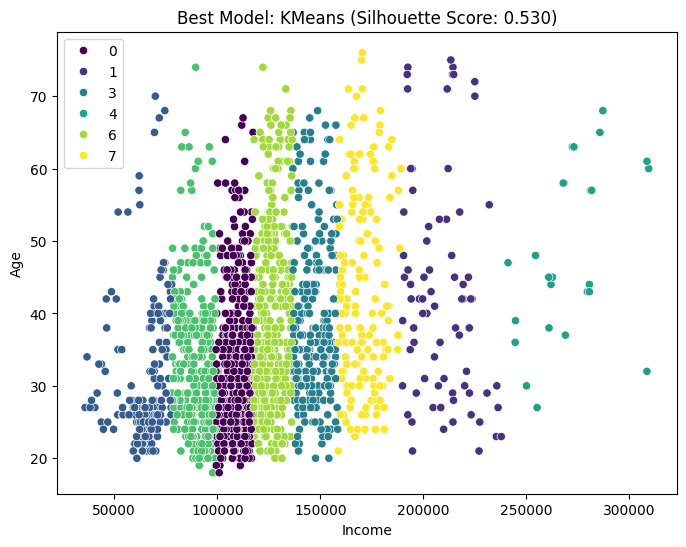

In [60]:
# Visualize the best model
feature1 = "Income"
feature2 = "Age"
labels = best_model.predict(dataset)

if isinstance(best_model, Pipeline) and 'hdbscan' in best_model.named_steps:
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[labels != -1] = True
    filtered_dataset = dataset[core_samples_mask]
    filtered_labels = labels[core_samples_mask]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=filtered_dataset[feature1], y=filtered_dataset[feature2], hue=filtered_labels, palette='viridis')
    plt.title(f'Best Model: {type(best_model.named_steps["hdbscan"]).__name__} (Silhouette Score: {best_silhouette:.3f})')
else:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=dataset[feature1], y=dataset[feature2], hue=labels, palette='viridis')
    if isinstance(best_model, Pipeline):
        model_name = type(best_model.named_steps[best_model.steps[-1][0]]).__name__
    else:
        model_name = type(best_model).__name__
    plt.title(f'Best Model: {model_name} (Silhouette Score: {best_silhouette:.3f})')

plt.show()